In [1]:
import numpy as np 
import pandas as pd 

In [2]:
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

**Load data from csv files.**

In [7]:
emotions_df = pd.read_csv("C:/SEAN/GA Tech Academics/Grad/Fall 2024/ML CSE 8803/ML-CSE-8803-Team-2/Emotions/Datasets/emotions.csv", header = 0)

In [8]:
print(emotions_df.shape)

(2132, 2549)


Extract the FFT columns from the dataset. The original dataset is over 2500 columns, so we absolutely need to reduce the dimensionality. Some of the columns are the result of Fast Fourier Transform (FFT). EEG signals are inherently time series data, but much of the brain’s cognitive and emotional information is encoded in specific frequency waves (e.g. alpha, beta, gamma). Thus FFT transforms raw EEG data into these frequency components, which are more interpretable and better suited for detecting emotional states.

In [9]:
emotions_df_fft_a = emotions_df.loc[:, 'fft_0_a':'fft_749_a']

In [10]:
emotions_df_fft_b = emotions_df.loc[:, 'fft_0_b':'fft_749_b']

In [11]:
emotions_df_fft_a.head()

,fft_0_a,fft_1_a,fft_2_a,fft_3_a,fft_4_a,fft_5_a,fft_6_a,fft_7_a,fft_8_a,fft_9_a,...,fft_740_a,fft_741_a,fft_742_a,fft_743_a,fft_744_a,fft_745_a,fft_746_a,fft_747_a,fft_748_a,fft_749_a
0,-520.0,398.00,-201.0,-201.0,398.00,-52.2,121.00,-64.0,-64.0,121.00,...,179.0,26.4,-12.9,-12.9,26.4,-474.00,442.0,-222.00,-222.00,442.0
1,66.2,-4.30,43.6,43.6,-4.30,66.0,-29.00,73.3,73.3,-29.00,...,184.0,17.0,-18.9,-18.9,17.0,189.00,-19.6,-8.37,-8.37,-19.6
2,-90.8,204.00,-77.1,-77.1,204.00,-488.0,415.00,-187.0,-187.0,415.00,...,-796.0,631.0,-261.0,-261.0,631.0,-86.40,176.0,-100.00,-100.00,176.0
3,119.0,6.25,10.9,10.9,6.25,-333.0,283.00,-144.0,-144.0,283.00,...,-474.0,439.0,-221.0,-221.0,439.0,272.00,-87.7,32.40,32.40,-87.7
4,59.0,-2.37,10.8,10.8,-2.37,118.0,-1.81,26.7,26.7,-1.81,...,30.7,50.3,-111.0,-111.0,50.3,-2.43,30.5,-152.00,-152.00,30.5


In [12]:
emotions_df_fft_b.head()

,fft_0_b,fft_1_b,fft_2_b,fft_3_b,fft_4_b,fft_5_b,fft_6_b,fft_7_b,fft_8_b,fft_9_b,...,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b
0,-508.0,438.00,-222.00,-222.00,438.00,143.0,59.40,5.05,5.05,59.40,...,74.3,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00
1,126.0,-4.00,7.42,7.42,-4.00,81.6,-22.30,35.30,35.30,-22.30,...,130.0,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57
2,-85.9,361.00,-62.20,-62.20,361.00,-558.0,684.00,-152.00,-152.00,684.00,...,-534.0,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00
3,69.5,3.89,12.10,12.10,3.89,-188.0,274.00,-200.00,-200.00,274.00,...,-183.0,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40
4,226.0,-27.40,147.00,147.00,-27.40,301.0,-8.48,138.00,138.00,-8.48,...,114.0,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60


In [14]:
def perform_feature_selection(df: pd.DataFrame, variance_threshold: float) -> pd.DataFrame:
    print("----------STARTING FEATURE SELECTION----------")
    X = df
    
    print("----------STARTING PCA----------")
    
    scaler = StandardScaler()
    scaled_X = scaler.fit_transform(X)

    # Perform PCA
    pca = PCA(n_components = 50)
    pca.fit_transform(scaled_X)
    
    print("----------FINISHED PCA----------")
    
    # Determine number of components needed to keep a certain threshold percentage of variance

    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    num_pc = np.argmax(cumulative_variance_ratio >= variance_threshold) + 1
    print("Number of principal components to keep", variance_threshold * 100, "% of variance:", num_pc)

    # Visualization
    plt.figure(figsize=(8, 6))

    # Line plot for cumulative explained variance (all points are initially red)
    plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', color='red', label='Cumulative explained variance', linestyle='-')

    # Use blue dots to denote every n-th point where n is divisible by 5
    for i in range(5, len(cumulative_variance_ratio) + 1, 5):
        plt.scatter(i, cumulative_variance_ratio[i - 1], color='blue', zorder=5) 
        
    plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

    plt.xlabel('# of Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Principal Components')
    plt.legend(loc='best')
    plt.show()
    
    # Find components that give the variance threshold.
    
    components_for_threshold = np.where(cumulative_variance_ratio >= variance_threshold)[0][0] + 1

    # Get the list of column names needed to reach the variance threshold.
    needed_columns = X.columns[:components_for_threshold]
    print("final kept columns:")
    print(df[needed_columns].head())
    print("----------FINISHED FEATURE SELECTION----------")
    return df[needed_columns]

Extract the output column (i.e. emotional state), and map the string labels to integers.

In [15]:
y = emotions_df.iloc[:, -1] # The last column contains the outputs
unique_y = y.unique()
print(unique_y)

['NEGATIVE' 'NEUTRAL' 'POSITIVE']


In [16]:
mapping = {
    'NEGATIVE': 0,
    'NEUTRAL': 1,
    'POSITIVE': 2
}

# Apply the mapping to y
y_mapped = y.map(mapping)

print(y_mapped.head(10))

0    0
1    1
2    2
3    2
4    1
5    1
6    2
7    0
8    1
9    0
Name: label, dtype: int64


----------STARTING FEATURE SELECTION----------
----------STARTING PCA----------
----------FINISHED PCA----------
Number of principal components to keep 90.0 % of variance: 10


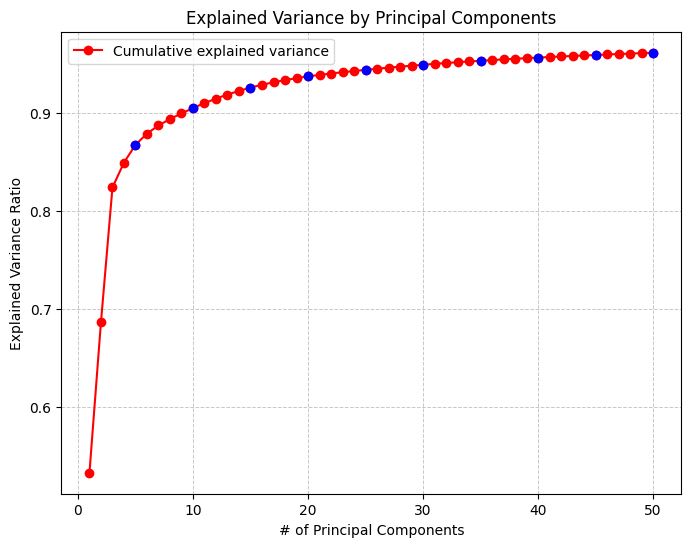

final kept columns:
   fft_0_a  fft_1_a  fft_2_a  fft_3_a  fft_4_a  fft_5_a  fft_6_a  fft_7_a  \
0   -520.0   398.00   -201.0   -201.0   398.00    -52.2   121.00    -64.0   
1     66.2    -4.30     43.6     43.6    -4.30     66.0   -29.00     73.3   
2    -90.8   204.00    -77.1    -77.1   204.00   -488.0   415.00   -187.0   
3    119.0     6.25     10.9     10.9     6.25   -333.0   283.00   -144.0   
4     59.0    -2.37     10.8     10.8    -2.37    118.0    -1.81     26.7   

   fft_8_a  fft_9_a  
0    -64.0   121.00  
1     73.3   -29.00  
2   -187.0   415.00  
3   -144.0   283.00  
4     26.7    -1.81  
----------FINISHED FEATURE SELECTION----------


In [23]:
emotions_df_fft_a_preprocessed = perform_feature_selection(emotions_df_fft_a, 0.9)

----------STARTING FEATURE SELECTION----------
----------STARTING PCA----------
----------FINISHED PCA----------
Number of principal components to keep 90.0 % of variance: 10


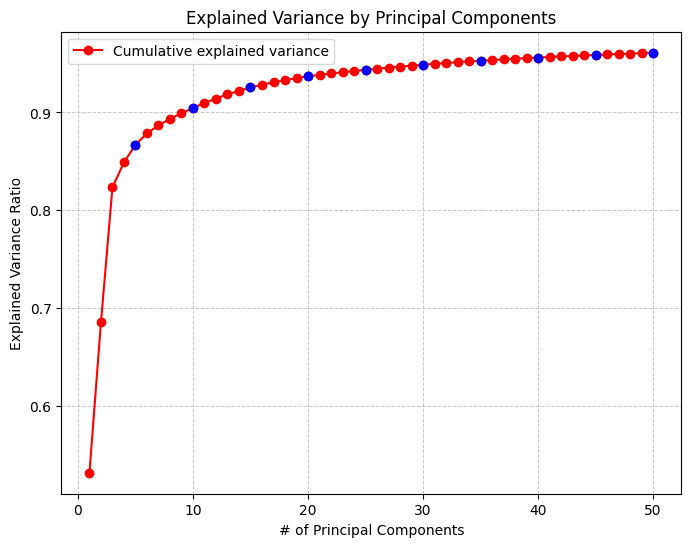

final kept columns:
   fft_0_b  fft_1_b  fft_2_b  fft_3_b  fft_4_b  fft_5_b  fft_6_b  fft_7_b  \
0   -508.0   438.00  -222.00  -222.00   438.00    143.0    59.40     5.05   
1    126.0    -4.00     7.42     7.42    -4.00     81.6   -22.30    35.30   
2    -85.9   361.00   -62.20   -62.20   361.00   -558.0   684.00  -152.00   
3     69.5     3.89    12.10    12.10     3.89   -188.0   274.00  -200.00   
4    226.0   -27.40   147.00   147.00   -27.40    301.0    -8.48   138.00   

   fft_8_b  fft_9_b  
0     5.05    59.40  
1    35.30   -22.30  
2  -152.00   684.00  
3  -200.00   274.00  
4   138.00    -8.48  
----------FINISHED FEATURE SELECTION----------


In [24]:
emotions_df_fft_b_preprocessed = perform_feature_selection(emotions_df_fft_b, 0.9)

**Train the model for detecting emotion. We use a deep learning approach.**

In [25]:
def train_emotion_classifier_tf(df: pd.DataFrame):
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(df, y_mapped, test_size = 0.2)
    
    # Reshape the input data to be compatible with the model we train
    X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
    
    # Create the model
    model = Sequential()

    # First LSTM layer
    model.add(LSTM(units = 256, return_sequences=True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.3))  # Add dropout to prevent overfitting

    # Second LSTM layer
    model.add(LSTM(units = 128, return_sequences=False))
    model.add(Dropout(0.3))

    # Fully connected layer
    model.add(Dense(units = 64, activation='relu'))
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(units = 3, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    
    # Train the model
    model.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_data=(X_test, y_test))
    
    # Evaluate the model on the test data
    accuracy = model.evaluate(X_test, y_test, verbose=0)[1]
    print(f'Test accuracy: {accuracy * 100:.2f}%')
    

In [26]:
train_emotion_classifier_tf(emotions_df_fft_a_preprocessed)

c:\Users\sean\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 1, 256)         │       273,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 478,979 (1.83 MB)

 Trainable params: 478,979 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6222 - loss: 0.8283 - val_accuracy: 0.8454 - val_loss: 0.4275
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8434 - loss: 0.4120 - val_accuracy: 0.8806 - val_loss: 0.3388
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8370 - loss: 0.3836 - val_accuracy: 0.8735 - val_loss: 0.3132
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8704 - loss: 0.3312 - val_accuracy: 0.8806 - val_loss: 0.3316
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8441 - loss: 0.3770 - val_accuracy: 0.8759 - val_loss: 0.3489
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8511 - loss: 0.3541 - val_accuracy: 0.8876 - val_loss: 0.3161
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8668 - loss: 0.3287 - val_accuracy: 0.8829 - val_loss: 0.3019
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8648 - loss: 0.3150 - val_accuracy: 0.8782 - val_los

In [27]:
train_emotion_classifier_tf(emotions_df_fft_b_preprocessed)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 1, 256)         │       273,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 478,979 (1.83 MB)

 Trainable params: 478,979 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6678 - loss: 0.8215 - val_accuracy: 0.8080 - val_loss: 0.4422
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8476 - loss: 0.4285 - val_accuracy: 0.8337 - val_loss: 0.4065
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8470 - loss: 0.3764 - val_accuracy: 0.8337 - val_loss: 0.4405
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8612 - loss: 0.3633 - val_accuracy: 0.8361 - val_loss: 0.4036
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8668 - loss: 0.3381 - val_accuracy: 0.8431 - val_loss: 0.4053
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8684 - loss: 0.3517 - val_accuracy: 0.8454 - val_loss: 0.3888
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8842 - loss: 0.3057 - val_accuracy: 0.8454 - val_loss: 0.3906
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8823 - loss: 0.3082 - val_accuracy: 0.8478 - val_lo

In [29]:
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier, self).__init__()
        self.lstm1 = nn.LSTM(input_size=32, hidden_size=256, batch_first=True, dropout=0.3, num_layers=1)
        self.lstm2 = nn.LSTM(input_size=256, hidden_size=128, batch_first=True, dropout=0.3, num_layers=1)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 3)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.dropout(self.relu(self.fc1(x[:, -1, :])))  
        x = self.dropout(self.fc2(x))
        return self.softmax(x)

In [156]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

In [30]:
def train_emotion_classifier_torch(df: pd.DataFrame, y) -> EmotionClassifier:
    # Split the data into train and test sets
    y_arr = y.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(df, y_arr, test_size=0.2)

    # Convert data to PyTorch tensors and reshape
    X_train = torch.tensor(X_train.values, dtype=torch.float32).unsqueeze(1)  
    X_test = torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(1)
    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)

    # Create data loaders
    train_data = TensorDataset(X_train, y_train)
    test_data = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

    # Create the model, loss function, and optimizer
    model = EmotionClassifier()
    criterion = nn.CrossEntropyLoss() # loss function
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    epochs = 50
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = torch.max(outputs, 1)[1]
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * (correct / total)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

    # Validate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = torch.max(outputs, 1)[1]
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * (correct / total)
    print(f'Test Accuracy: {test_accuracy:.2f}%')
    
    return model

In [31]:
emotion_classifier_torch = train_emotion_classifier_torch(emotions_df_fft_a_preprocessed, y_mapped)

c:\Users\sean\miniconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Users\sean\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/50, Loss: 50.1388, Train Accuracy: 64.63%
Epoch 2/50, Loss: 41.3865, Train Accuracy: 78.18%
Epoch 3/50, Loss: 40.6274, Train Accuracy: 79.30%
Epoch 4/50, Loss: 39.9537, Train Accuracy: 80.06%
Epoch 5/50, Loss: 40.2551, Train Accuracy: 79.71%
Epoch 6/50, Loss: 39.8746, Train Accuracy: 79.71%
Epoch 7/50, Loss: 39.9779, Train Accuracy: 79.18%
Epoch 8/50, Loss: 40.2096, Train Accuracy: 79.41%
Epoch 9/50, Loss: 39.7283, Train Accuracy: 80.12%
Epoch 10/50, Loss: 40.5305, Train Accuracy: 78.71%
Epoch 11/50, Loss: 40.1498, Train Accuracy: 80.06%
Epoch 12/50, Loss: 39.4760, Train Accuracy: 80.70%
Epoch 13/50, Loss: 40.2517, Train Accuracy: 79.24%
Epoch 14/50, Loss: 39.9512, Train Accuracy: 80.47%
Epoch 15/50, Loss: 40.2336, Train Accuracy: 79.53%
Epoch 16/50, Loss: 40.0131, Train Accuracy: 79.88%
Epoch 17/50, Loss: 39.9839, Train Accuracy: 80.06%
Epoch 18/50, Loss: 39.5841, Train Accuracy: 80.12%
Epoch 19/50, Loss: 40.2026, Train Accuracy: 79.94%
Epoch 20/50, Loss: 39.6662, Train Accura

In [32]:
train_emotion_classifier_torch(emotions_df_fft_b_preprocessed, y_mapped)

c:\Users\sean\miniconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/50, Loss: 49.8929, Train Accuracy: 63.99%
Epoch 2/50, Loss: 41.7376, Train Accuracy: 77.65%
Epoch 3/50, Loss: 40.8462, Train Accuracy: 78.12%
Epoch 4/50, Loss: 40.2210, Train Accuracy: 80.06%
Epoch 5/50, Loss: 39.9046, Train Accuracy: 80.00%
Epoch 6/50, Loss: 40.6095, Train Accuracy: 78.89%
Epoch 7/50, Loss: 39.8374, Train Accuracy: 80.65%
Epoch 8/50, Loss: 40.1388, Train Accuracy: 79.71%
Epoch 9/50, Loss: 39.8644, Train Accuracy: 80.76%
Epoch 10/50, Loss: 39.7203, Train Accuracy: 81.29%
Epoch 11/50, Loss: 39.8240, Train Accuracy: 79.06%
Epoch 12/50, Loss: 39.6797, Train Accuracy: 80.76%
Epoch 13/50, Loss: 39.8124, Train Accuracy: 80.70%
Epoch 14/50, Loss: 40.0881, Train Accuracy: 79.82%
Epoch 15/50, Loss: 39.7763, Train Accuracy: 79.24%
Epoch 16/50, Loss: 40.1080, Train Accuracy: 79.24%
Epoch 17/50, Loss: 39.7985, Train Accuracy: 80.00%
Epoch 18/50, Loss: 39.8248, Train Accuracy: 79.88%
Epoch 19/50, Loss: 39.5164, Train Accuracy: 81.00%
Epoch 20/50, Loss: 39.8689, Train Accura

EmotionClassifier(
  (lstm1): LSTM(32, 256, batch_first=True, dropout=0.3)
  (lstm2): LSTM(256, 128, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)